In [12]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.7 MB/s eta 0:00:00


In [14]:
# Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam


In [53]:
# from keras.utils.vis_utils import plot_model

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [18]:
!ls drive/My\ Drive

 1080652.jpg
'132 PROB SETS'
'151 Problem Set 1.pdf'
'165 Camera Setup'
'167 Activity 6: Color Science '
'170 Problem Set 1.pdf'
 184
 184_act_1
 191_Data
'191 Set A'
'191 - SET C EXPERIMENTS'
'192 Exp 2'
'192 Experiment 3'
'192 Experiment 3 (New Data)'
 192_SetB_Exp3.xlsx
'192 Set B - Experiment 3.gsheet'
 192_SetC_Experiment_1.gsheet
 20210709_190543.jpg
 20210709_190732.jpg
 20210713_010723.jpg
 20210724_020633.jpg
 20220503_174636.jpg
 20220503_175058.jpg
 20230126_102907.jpg
 20230205_111114.jpg
 20230205_185156.jpg
 20230227_170223.jpg
 20230227_170245.jpg
 20230303_110756.jpg
 20230315_170009.jpg
 20230403_153905.jpg
 20230403_154126.jpg
 20230403_154603.jpg
 20230606_233247.jpg
 20230607_173628.jpg
'20230719_204157 (1).jpg'
 20230719_204157.jpg
'20230719_204250 (1).jpg'
 20230719_204250.jpg
 20230719_205910.mp4
 20230719_210316.jpg
'20230719_210317 (1).jpg'
 20230719_210317.jpg
 20230719_211938.mp4
 20230719_213138.mp4
 20230719_214628.mp4
 20230719_223236.jpg
 20230725_201704.

In [19]:
file_path = "/content/drive/My Drive/App Physics 157/"

In [20]:
#Get the Dataset
df=pd.read_csv(file_path + 'TSLA.csv', na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)
df.head()

<ipython-input-20-d9fdad4787a7>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv(file_path + 'TSLA.csv', na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)


,Close/Last,Volume,Open,High,Low
Date,,,,,
2024-05-24,$179.24,65584480,$174.835,$180.08,$173.73
2024-05-23,$173.74,71975500,$181.80,$181.90,$173.26
2024-05-22,$180.11,88313480,$182.85,$183.80,$178.12
2024-05-21,$186.60,115266500,$175.51,$186.875,$174.71
2024-05-20,$174.95,61727430,$177.56,$177.754,$173.52


In [21]:
#Print the shape of Dataframe
print("Dataframe Shape: ", df. shape)

Dataframe Shape:  (250, 5)


Text(0, 0.5, 'Close/Last Price ($)')

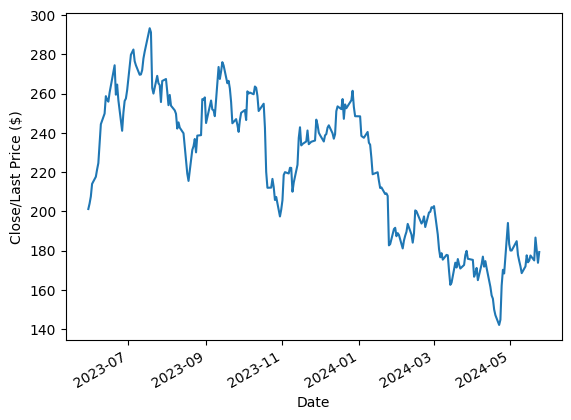

In [22]:
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df['Close/Last'].plot()
plt.ylabel('Close/Last Price ($)')

In [23]:
# plt.figure(figsize=(10, 6))
# plt.plot(df.index, df['Close/Last'], label='Close/Last')
# plt.xlabel('Date')
# plt.ylabel('Close/Last Price')
# plt.title('Tesla Close/Last Price Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()

In [24]:
#Set Target Variable
df['Open'] = df['Open'].str.replace('$', '').astype(float)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)
output_var = pd.DataFrame(df['Close/Last'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [25]:
#Scaling

scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2024-05-24,0.220446,0.230158,0.231741,0.031361
2024-05-23,0.265243,0.241912,0.228623,0.066084
2024-05-22,0.271996,0.254181,0.260869,0.154850
2024-05-21,0.224788,0.274039,0.238244,0.301288
2024-05-20,0.237973,0.215137,0.230348,0.010405


In [26]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [27]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

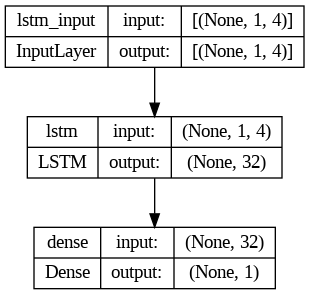

In [28]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

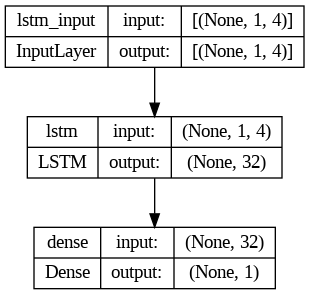

In [87]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [45]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6611
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6565
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6519
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6473
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6427
Epoch 6/100
29/29 [==============================] - 0s 3ms/step - loss: 10.6380
Epoch 7/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6334
Epoch 8/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6288
Epoch 9/100
29/29 [==============================] - 0s 3ms/step - loss: 10.6242
Epoch 10/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6196
Epoch 11/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6150
Epoch 12/100
29/29 [==============================] - 0s 2ms/step - loss: 10.6104
Epoch 13/100
29/29 [=====

In [46]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

1/1 [==============================] - 0s 19ms/step


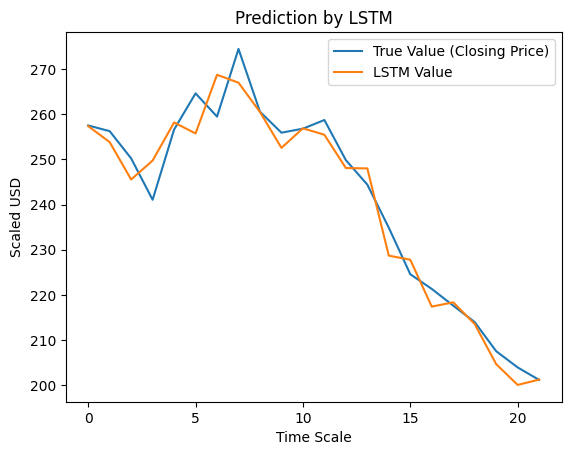

In [48]:
#Predicted vs True Close Value – LSTM
plt.plot(y_test, label='True Value (Closing Price)')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [52]:
# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Squared Error (MSE): {mse}")
# print(f"Root Mean Squared Error (RMSE): {rmse}")
# print(f"R-squared (R²): {r2}")